## Predict delta PSI of GTEx A3SS events with COSSMO

In [1]:
import kipoi
from kipoi.model import KerasModel
import numpy as np
import pandas as pd
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
%matplotlib inline 

from mmsplice.exon_dataloader import ExonDataset

from kipoi.data import DataLoader
from kipoi.data_utils import numpy_collate

from keras.models import load_model
from concise.preprocessing import encodeDNA

%load_ext autoreload
%autoreload 2

projectDIR = "../../data/"

/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/modules/i12g/anaconda/3-5.0.1/envs/mmsplice-manuscript/li

In [2]:
dl1 = ExonDataset(projectDIR+"gtex/A3SS_SA1_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(40,40))

In [3]:
dl2 = ExonDataset(projectDIR+"gtex/A3SS_SA2_variant.csv",
           projectDIR+"shared/hg19.fa", split_seq=False, overhang=(40,40))

In [4]:
dl1 = DataLoader(dl1, batch_size=dl1.__len__(), collate_fn=numpy_collate, shuffle=False)
dl1 = iter(dl1)
dt1 = next(dl1)

In [5]:
dl2 = DataLoader(dl2, batch_size=dl2.__len__(), collate_fn=numpy_collate, shuffle=False)
dl2 = iter(dl2)
dt2 = next(dl2)

In [6]:
csv = projectDIR+"gtex/A3SS_SA1_variant.csv"
csvf = pd.read_csv(csv, sep=',', index_col=0)

In [7]:
# WT_ACC: Exon with 40 nt flanking
csvf['WT_ACC1'] = dt1['inputs']['seq']
csvf['WT_ACC2'] = dt2['inputs']['seq']
csvf['MUT_ACC1'] = dt1['mut_inputs']['seq']
csvf['MUT_ACC2'] = dt2['mut_inputs']['seq']

In [8]:
csvf = csvf.reset_index()

## Process for COSSMO

In [9]:
import tensorflow as tf
from mmsplice.vcf_dataloader import FastaSeq
from mmsplice.IntervalTree import Interval

In [10]:
fasta = FastaSeq(projectDIR+'shared/hg19.fa')

In [11]:
from mmsplice.vcf_dataloader import FastaSeq

# fasta = FastaSeq(fasta, as_raw=False)
def get_constseq_acceptor(event, fasta):
    # return 1. alt ss positions, const pos
    # 2. const sequence
    event_split = event.split(":")
    strand = event_split[3].split("@")[0]
    if strand == "+":
        const_pos = int(event_split[2])
        alt_ss_pos = event_split[4].split("|")
    else:
        const_pos = int(event_split[1])
        alt_ss_pos = event_split[4].split("|")[::-1]
    alt_ss_pos = [int(i) for i in alt_ss_pos]
    chrom = event_split[0]
    if strand == "+":
        const = Interval(chrom=chrom, start=const_pos-40+1, end=const_pos+40, strand=strand)
    else:
        const = Interval(chrom=chrom, start=const_pos-40, end=const_pos+40-1, strand=strand)
        const_pos = -const_pos
        alt_ss_pos = [-i for i in alt_ss_pos]
    constseq = fasta.getSeq(const)
    return constseq, const_pos, alt_ss_pos

In [12]:
# process one row of csvf, return cossmo inputs
def cossmo_inputs(x, fasta, placeholder, wt=True):
    constseq, const_pos, alt_ss_pos = get_constseq_acceptor(x.event_name, fasta)
    if wt:
        ACC1seq = x.WT_ACC1
        ACC2seq = x.WT_ACC2
    else:
        ACC1seq = x.MUT_ACC1
        ACC2seq = x.MUT_ACC2
    alt_dna_seq = [ACC1seq[:80], ACC2seq[:80]]
    rns_seq = [constseq[:40]+ACC1seq[40:80], constseq[:40]+ACC2seq[40:80]]
    return {placeholders['alt_dna_seq']: alt_dna_seq,
            placeholders['const_site_position']: const_pos,
            placeholders['const_dna_seq']: constseq,
            placeholders['n_alt_ss']: 2,
            placeholders['alt_ss_position']: alt_ss_pos,
            placeholders['rna_seq']: rns_seq}

In [13]:
def transpose_collate(collate, placeholders):
    collate[placeholders['alt_dna_seq']] = np.array(collate[placeholders['alt_dna_seq']]).T
    collate[placeholders['alt_ss_position']] = np.array(collate[placeholders['alt_ss_position']]).T
    collate[placeholders['rna_seq']] = np.array(collate[placeholders['rna_seq']]).T
    return collate

In [14]:
session = tf.Session()
sm = tf.saved_model.loader.load(
  session, 
  [tf.saved_model.tag_constants.SERVING], 
  projectDIR+'COSSMO/saved_model_acceptor_lstm_1_fold0'
)
placeholders = {n.name[n.name.rfind('/') + 1:-2]: n
  for n in tf.get_collection('inputs')}
psi_prediction, logits = tf.get_collection('outputs')

INFO:tensorflow:Restoring parameters from ../../data/COSSMO/saved_model_acceptor_lstm_1_fold0/variables/variables


2018-11-16 20:12:46,433 [INFO] Restoring parameters from ../../data/COSSMO/saved_model_acceptor_lstm_1_fold0/variables/variables


In [15]:
WT_inputs = numpy_collate(csvf.apply(lambda x: cossmo_inputs(x, fasta, placeholders, wt=True), axis=1))
WT_inputs = transpose_collate(WT_inputs, placeholders)
pred_wt = session.run((psi_prediction, logits), feed_dict=WT_inputs)

In [16]:
MUT_inputs = numpy_collate(csvf.apply(lambda x: cossmo_inputs(x, fasta, placeholders, wt=False), axis=1))
MUT_inputs = transpose_collate(MUT_inputs, placeholders)
pred_mut = session.run((psi_prediction, logits), feed_dict=MUT_inputs)

## MaxEnt

In [17]:
from maxentpy import maxent_fast
from maxentpy.maxent_fast import load_matrix
matrix3 = load_matrix(3)

def fast_score(cossmo_seq):
    return maxent_fast.score3(cossmo_seq[20:43], matrix=matrix3)

def score_maxent(x, hetero=False):
    wt = fast_score(x.WT_ACC1) - fast_score(x.WT_ACC2)
    mut = fast_score(x.MUT_ACC1) - fast_score(x.MUT_ACC2)
    if hetero:
        return (wt+mut)/2 - wt
    else:
        return mut - wt

In [18]:
dMaxEnt_homo = csvf.apply(score_maxent, axis=1, hetero=False)
dMaxEnt_hetero = csvf.apply(score_maxent, axis=1, hetero=True)

## Plot

In [19]:
df = pd.read_csv(projectDIR+"gtex/A3SS_PSI.csv", index_col=0)
df = df.reset_index()

In [20]:
DPSI_PRED = pred_mut[0][0][:,0] - pred_wt[0][0][:,0]

In [21]:
df['DPSI_PRED_HOMO'] = pred_mut[0][0][:,0] - pred_wt[0][0][:,0]
df['DPSI_PRED_HETERO'] = (pred_mut[0][0][:,0] + pred_wt[0][0][:,0]) / 2 - pred_wt[0][0][:,0]

df['dMaxEnt_homo'] = dMaxEnt_homo
df['dMaxEnt_hetero'] = dMaxEnt_hetero

df_HOMO = df[~df.HOMO_MEAN.isna()]
df_HETERO = df[~df.HETERO_MEAN.isna()]

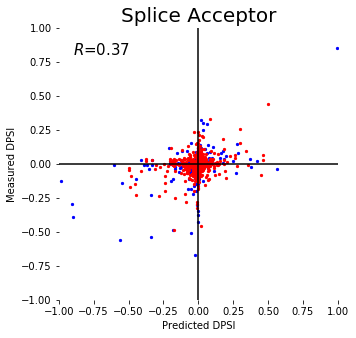

In [22]:
pred = np.concatenate([df_HOMO['DPSI_PRED_HOMO'], df_HETERO['DPSI_PRED_HETERO']])
measured = np.concatenate([df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN']])
r = pearsonr(pred, measured)[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['DPSI_PRED_HOMO'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['DPSI_PRED_HETERO'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.text(-0.9,0.9,'$R$=%0.2f' %r,fontsize=15,ha='left',va='top')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.set_title("Splice Acceptor", fontsize=20)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

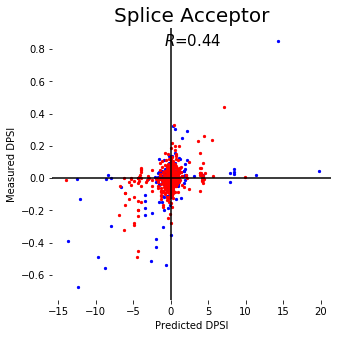

In [23]:
pred = np.concatenate([df_HOMO['dMaxEnt_homo'], df_HETERO['dMaxEnt_hetero']])
measured = np.concatenate([df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN']])
r = pearsonr(pred, measured)[0]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax.axis([-1,1,-1,1])
ax.scatter(df_HOMO['dMaxEnt_homo'], df_HOMO['HOMO_MEAN'] - df_HOMO['WT_MEAN'], s=5, c='b')
ax.scatter(df_HETERO['dMaxEnt_hetero'], df_HETERO['HETERO_MEAN'] - df_HETERO['WT_MEAN'], s=5, c='r')
ax.text(-0.9,0.9,'$R$=%0.2f' %r,fontsize=15,ha='left',va='top')
ax.set_xlabel("Predicted DPSI")
ax.set_ylabel("Measured DPSI")
ax.set_title("Splice Acceptor", fontsize=20)
ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k')
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [24]:
df_HOMO.to_csv(projectDIR + "gtex/COSSMO_SA_HOMO.csv")
df_HETERO.to_csv(projectDIR + "gtex/COSSMO_SA_HETERO.csv")